In [1]:
import re
import glob
import matplotlib.pyplot as plt
import dlib
import cv2
import numpy as np
import os
import shutil
import time
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
# from tqdm import tqdm
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
import torchvision.models as models
from torchvision.datasets import ImageFolder
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings(action='ignore')
import random
import pandas as pd
import os.path
import seaborn as sns

from pathlib import Path
from time import perf_counter

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score
from IPython.display import Markdown, display
from sklearn import preprocessing

from sklearn.utils.class_weight import compute_class_weight



In [2]:
# 하이퍼파라미터 설정
learning_rate = 0.001
batch_size = 20
num_epochs = 10
SEED = 42

In [100]:
# 데이터셋 경로
data_path = 'C:/Users/jungh/final_project/preprocessed_seasons_img'
classes = ['spring', 'summer', 'fall', 'winter']
num_classes = len(classes)
image_size = (128, 128)

In [102]:
class CustomDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    
    return image, label

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64 * (image_size[0] // 4) * (image_size[1] // 4), 64)
    self.bn3 = nn.BatchNorm1d(64)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(64, num_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn3(x)
    x = self.relu3(x)
    x = self.fc2(x)
    return x
  


In [103]:

def load_dataset():
  x = []
  y = []
  
  for i, class_name in enumerate(classes):
    class_path = os.path.join(data_path, class_name)
    for image_name in os.listdir(class_path):
      image_path = os.path.join(class_path, image_name)
      image = cv2.imread(image_path)
      image = cv2.resize(image, image_size)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      x.append(image)
      y.append(i)
  
  x = np.array(x)
  y = np.array(y)
  
  return x, y
    


In [105]:
x, y = load_dataset()
# 데이터셋을 훈련 세트와 임시 데이터로 분할 (비율: 80% 훈련, 20% 임시 데이터)
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size = 0.2, random_state=SEED, stratify=y)

# 임시 데이터를 다시 훈련 세트와 검증 세트로 분할 (비율: 75% 훈련, 25% 검증)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=SEED, stratify=y_train_temp)

x_train = x_train.reshape(-1, 3, image_size[0], image_size[1])
x_val = x_val.reshape(-1, 3, image_size[0], image_size[1])
x_test = x_test.reshape(-1, 3, image_size[0], image_size[1])

텐서로 변환
x_train = torch.from_numpy(x_train).float() / 255.0
x_val = torch.from_numpy(x_val).float() / 255.0
x_test = torch.from_numpy(x_test).float() / 255.0

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

In [117]:
unique_labels, label_counts = np.unique(y_test, return_counts=True)

# 각 클래스 라벨의 개수 확인
for label, count in zip(unique_labels, label_counts):
    print(f"클래스 라벨 {label}: {count}개")

클래스 라벨 0: 712개
클래스 라벨 1: 845개
클래스 라벨 2: 599개
클래스 라벨 3: 484개


In [112]:
y_test.unique

AttributeError: 'numpy.ndarray' object has no attribute 'unique'

In [93]:
y_test.value_counts

<bound method IndexOpsMixin.value_counts of 513        fall
2460       fall
1861       fall
4751     spring
1676       fall
          ...  
10213    summer
7552     summer
11346    winter
11000    winter
11585    winter
Name: label, Length: 2640, dtype: object>

In [23]:
train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().float().to(device)
model.conv1 = nn.Conv2d(x.shape[3], 32, kernel_size=3, stride=1, padding=1)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [88]:
val_accuracy

76.78030303030303

In [13]:
best_val_accuracy = 0.0
for epoch in range(num_epochs):
  model.train()
  running_loss = 0.0
  
  
  with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as progress_bar:
    for images, labels in train_dataloader:
      images = images.float().to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      outputs = model(images)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()
      
      running_loss += loss.item()
      progress_bar.set_postfix(loss=running_loss / (len(train_dataloader)))
      progress_bar.update()
  
  
  epoch_loss = running_loss / len(train_dataloader)
  model.eval()
  correct = 0
  total = 0
  
  
  
  with torch.no_grad():
    for images, labels in val_dataloader:
      images = images.to(device)
      labels = labels.to(device)

      outputs = model(images)
      _, predicted = torch.max(outputs.data, 1)

      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  val_accuracy = 100 * correct / total

  print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

# 검증 세트의 정확도가 이전에 기록한 최고 정확도보다 높으면 모델 저장
  if val_accuracy > best_val_accuracy:
      best_val_accuracy = val_accuracy
      torch.save(model.state_dict(), 'best_model.pt')

Epoch 1/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 1/30: Train Loss: 0.7283, Val Accuracy: 70.30%


Epoch 2/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 2/30: Train Loss: 0.4755, Val Accuracy: 72.88%


Epoch 3/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 3/30: Train Loss: 0.4115, Val Accuracy: 80.30%


Epoch 4/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 4/30: Train Loss: 0.3816, Val Accuracy: 79.39%


Epoch 5/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 5/30: Train Loss: 0.3172, Val Accuracy: 78.45%


Epoch 6/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 6/30: Train Loss: 0.2768, Val Accuracy: 86.10%


Epoch 7/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 7/30: Train Loss: 0.2256, Val Accuracy: 84.36%


Epoch 8/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 8/30: Train Loss: 0.1874, Val Accuracy: 67.69%


Epoch 9/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 9/30: Train Loss: 0.1565, Val Accuracy: 77.01%


Epoch 10/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 10/30: Train Loss: 0.1583, Val Accuracy: 79.70%


Epoch 11/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 11/30: Train Loss: 0.1145, Val Accuracy: 82.35%


Epoch 12/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 12/30: Train Loss: 0.1068, Val Accuracy: 82.73%


Epoch 13/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 13/30: Train Loss: 0.0940, Val Accuracy: 79.02%


Epoch 14/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 14/30: Train Loss: 0.0909, Val Accuracy: 73.18%


Epoch 15/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 15/30: Train Loss: 0.0695, Val Accuracy: 78.22%


Epoch 16/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 16/30: Train Loss: 0.0676, Val Accuracy: 82.69%


Epoch 17/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 17/30: Train Loss: 0.0687, Val Accuracy: 81.17%


Epoch 18/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 18/30: Train Loss: 0.0624, Val Accuracy: 79.02%


Epoch 19/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 19/30: Train Loss: 0.0495, Val Accuracy: 80.30%


Epoch 20/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 20/30: Train Loss: 0.0532, Val Accuracy: 81.25%


Epoch 21/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 21/30: Train Loss: 0.0453, Val Accuracy: 79.58%


Epoch 22/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 22/30: Train Loss: 0.0448, Val Accuracy: 81.55%


Epoch 23/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 23/30: Train Loss: 0.0443, Val Accuracy: 78.07%


Epoch 24/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 24/30: Train Loss: 0.0586, Val Accuracy: 80.80%


Epoch 25/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 25/30: Train Loss: 0.0319, Val Accuracy: 81.40%


Epoch 26/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 26/30: Train Loss: 0.0244, Val Accuracy: 82.05%


Epoch 27/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 27/30: Train Loss: 0.0382, Val Accuracy: 71.55%


Epoch 28/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 28/30: Train Loss: 0.0519, Val Accuracy: 79.43%


Epoch 29/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 29/30: Train Loss: 0.0333, Val Accuracy: 79.39%


Epoch 30/30:   0%|          | 0/396 [00:00<?, ?batch/s]

Epoch 30/30: Train Loss: 0.0375, Val Accuracy: 76.78%


In [28]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
correct = 0
total = 0

In [85]:
correct

2252

In [86]:
total

2640

In [29]:
with torch.no_grad():
  for images, labels in test_dataloader:
    images = images.float().to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    

test_accuracy = 100 * correct / total 
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 85.30%


In [87]:
outputs

tensor([[-8.8483,  6.6128, -4.5836, -2.0851]])

## ------------------------------------

In [22]:
# 하이퍼파라미터 설정
learning_rate = 0.001
batch_size = 64
num_epochs = 30
SEED = 42
# 데이터셋 경로
data_path = 'C:/Users/jungh/final_project/preprocessed_seasons_img'
classes = ['spring', 'summer', 'fall', 'winter']
num_classes = len(classes)
image_size = (128, 128)

In [23]:
class CustomDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels
    
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    
    return image, label

class MyModel(nn.Module):
  def __init__(self):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten = nn.Flatten()
    self.fc1 = nn.Linear(64 * (image_size[0] // 4) * (image_size[1] // 4), 64)
    self.bn3 = nn.BatchNorm1d(64)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(64, num_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.maxpool(x)
    x = self.flatten(x)
    x = self.fc1(x)
    x = self.bn3(x)
    x = self.relu3(x)
    x = self.fc2(x)
    return x
  


In [24]:
def load_dataset(data_path, image_size):
    x = []
    y = []
    classes = os.listdir(data_path)

    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = cv2.imread(image_path)
            image = cv2.resize(image, image_size)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            x.append(image)
            y.append(i)

    x = np.array(x)
    y = np.array(y)

    return x, y

In [25]:
x, y = load_dataset(data_path, image_size)

# 데이터셋을 훈련 세트와 임시 데이터로 분할 (비율: 80% 훈련, 20% 임시 데이터)
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size = 0.2, random_state=SEED, stratify=y)

# 임시 데이터를 다시 훈련 세트와 검증 세트로 분할 (비율: 75% 훈련, 25% 검증)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=SEED, stratify=y_train_temp)

x_train = x_train.reshape(-1, 3, image_size[0], image_size[1])
x_val = x_val.reshape(-1, 3, image_size[0], image_size[1])
x_test = x_test.reshape(-1, 3, image_size[0], image_size[1])

# 텐서로 변환
x_train = torch.from_numpy(x_train).float() / 255.0
x_val = torch.from_numpy(x_val).float() / 255.0
x_test = torch.from_numpy(x_test).float() / 255.0

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

In [26]:
# 클래스별 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [27]:
unique_labels, label_counts = np.unique(y_test, return_counts=True)

# 각 클래스 라벨의 개수 확인
for label, count in zip(unique_labels, label_counts):
    print(f"클래스 라벨 {label}: {count}개")

클래스 라벨 0: 599개
클래스 라벨 1: 712개
클래스 라벨 2: 845개
클래스 라벨 3: 484개


In [28]:

train_dataset = CustomDataset(x_train, y_train)
val_dataset = CustomDataset(x_val, y_val)
test_dataset = CustomDataset(x_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel().float().to(device)
model.conv1 = nn.Conv2d(x.shape[3], 32, kernel_size=3, stride=1, padding=1)
criterion = nn.CrossEntropyLoss(weight=class_weights.to(device))
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
save_path = 'best_model.pt'

In [29]:
def train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, save_path):
    best_val_accuracy = 0.0
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = [] 
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        with tqdm(total=len(train_dataloader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as progress_bar:
            for images, labels in train_dataloader:
                images = images.float().to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item()
                progress_bar.set_postfix(loss=running_loss / (len(train_dataloader)))
                progress_bar.update()

                _, predicted_train = torch.max(outputs.data, 1)
                total_train += labels.size(0)
                correct_train += (predicted_train == labels).sum().item()
                
        epoch_loss = running_loss / len(train_dataloader)
        train_losses.append(epoch_loss)
        
        train_accuracy = 100 * correct_train / total_train
        train_accuracies.append(train_accuracy)
        
        model.eval()
        correct = 0
        total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_dataloader:
                images = images.to(device)
                labels = labels.to(device)

                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()  

                _, predicted = torch.max(outputs.data, 1)

                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_accuracy = 100 * correct / total
        val_loss /= len(val_dataloader)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch + 1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

        # 검증 세트의 정확도가 이전에 기록한 최고 정확도보다 높으면 모델 저장
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            torch.save(model.state_dict(), save_path)

    print("Training completed!")
    return train_losses, val_losses, train_accuracies, val_accuracies

In [30]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, save_path)

Epoch 1/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 1/30: Train Loss: 0.8135, Val Loss: 2.5756, Val Accuracy: 36.21%


Epoch 2/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 2/30: Train Loss: 0.4655, Val Loss: 1.5467, Val Accuracy: 54.43%


Epoch 3/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 3/30: Train Loss: 0.3437, Val Loss: 0.4459, Val Accuracy: 82.58%


Epoch 4/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 4/30: Train Loss: 0.2756, Val Loss: 0.3988, Val Accuracy: 82.23%


Epoch 5/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 5/30: Train Loss: 0.2195, Val Loss: 0.9270, Val Accuracy: 71.63%


Epoch 6/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 6/30: Train Loss: 0.1582, Val Loss: 0.5333, Val Accuracy: 80.91%


Epoch 7/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 7/30: Train Loss: 0.1226, Val Loss: 0.6286, Val Accuracy: 80.64%


Epoch 8/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 8/30: Train Loss: 0.1037, Val Loss: 0.4522, Val Accuracy: 81.33%


Epoch 9/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 9/30: Train Loss: 0.0770, Val Loss: 0.6168, Val Accuracy: 78.22%


Epoch 10/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 10/30: Train Loss: 0.0604, Val Loss: 2.1669, Val Accuracy: 59.17%


Epoch 11/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 11/30: Train Loss: 0.0584, Val Loss: 0.8965, Val Accuracy: 76.78%


Epoch 12/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 12/30: Train Loss: 0.0637, Val Loss: 1.0204, Val Accuracy: 74.66%


Epoch 13/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 13/30: Train Loss: 0.0448, Val Loss: 0.4949, Val Accuracy: 84.09%


Epoch 14/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 14/30: Train Loss: 0.0251, Val Loss: 0.6663, Val Accuracy: 78.98%


Epoch 15/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 15/30: Train Loss: 0.0215, Val Loss: 0.7012, Val Accuracy: 79.24%


Epoch 16/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 16/30: Train Loss: 0.0197, Val Loss: 0.4946, Val Accuracy: 83.60%


Epoch 17/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 17/30: Train Loss: 0.0218, Val Loss: 0.9536, Val Accuracy: 76.40%


Epoch 18/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 18/30: Train Loss: 0.0169, Val Loss: 0.5686, Val Accuracy: 82.50%


Epoch 19/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 19/30: Train Loss: 0.0227, Val Loss: 0.5337, Val Accuracy: 82.61%


Epoch 20/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 20/30: Train Loss: 0.0181, Val Loss: 0.9302, Val Accuracy: 76.89%


Epoch 21/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 21/30: Train Loss: 0.0163, Val Loss: 0.9672, Val Accuracy: 77.05%


Epoch 22/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 22/30: Train Loss: 0.0351, Val Loss: 0.8423, Val Accuracy: 77.99%


Epoch 23/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 23/30: Train Loss: 0.0259, Val Loss: 0.8699, Val Accuracy: 79.28%


Epoch 24/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 24/30: Train Loss: 0.0217, Val Loss: 0.6682, Val Accuracy: 81.78%


Epoch 25/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 25/30: Train Loss: 0.0232, Val Loss: 0.9158, Val Accuracy: 76.78%


Epoch 26/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 26/30: Train Loss: 0.0483, Val Loss: 1.4884, Val Accuracy: 72.54%


Epoch 27/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 27/30: Train Loss: 0.0387, Val Loss: 0.7170, Val Accuracy: 80.64%


Epoch 28/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 28/30: Train Loss: 0.0185, Val Loss: 0.6844, Val Accuracy: 81.86%


Epoch 29/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 29/30: Train Loss: 0.0203, Val Loss: 0.6263, Val Accuracy: 82.80%


Epoch 30/30:   0%|          | 0/124 [00:00<?, ?batch/s]

Epoch 30/30: Train Loss: 0.0232, Val Loss: 0.6265, Val Accuracy: 83.37%
Training completed!


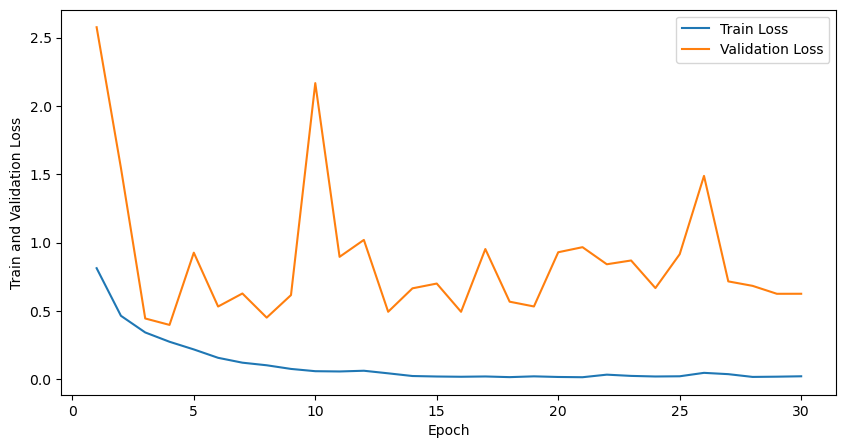

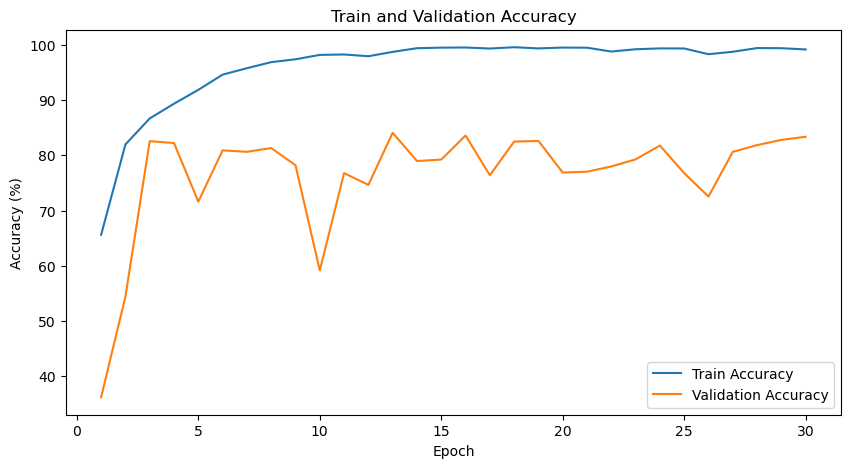

In [31]:
# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Train and Validation Loss')
plt.legend()
plt.show()

# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model.pt'))
model.eval()
correct = 0
total = 0

In [ ]:
with torch.no_grad():
  for images, labels in test_dataloader:
    images = images.float().to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    

test_accuracy = 100 * correct / total 
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 85.30%


## Model3

In [32]:
# 하이퍼파라미터 설정
learning_rate = 0.001
batch_size = 64
num_epochs = 30
SEED = 42
# 데이터셋 경로
data_path = 'C:/Users/jungh/final_project/preprocessed_seasons_img'
classes = ['spring', 'summer', 'fall', 'winter']
num_classes = len(classes)
image_size = (128, 128)

In [164]:
from PIL import Image


In [33]:
# 데이터 증강을 위한 변환 함수 정의
train_transform = transforms.Compose([
    # transforms.RandomResizedCrop(image_size),
    # transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomAutocontrast(),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
val_transform = transforms.Compose([
    # transforms.Resize(image_size),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
test_transform = transforms.Compose([
    # transforms.Resize(image_size),
    # transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


class CustomDataset(Dataset):
  def __init__(self, images, labels, transform=None):
    self.images = images
    self.labels = labels
    self.transform = transform
    
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image = self.images[idx]
    label = self.labels[idx]
    
    
    if self.transform:
      image = self.transform(image)
    
    return image, label

class MyModel(nn.Module):
  def __init__(self, input_channels):
    super(MyModel, self).__init__()
    self.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)
    self.bn1 = nn.BatchNorm2d(32)
    self.relu1 = nn.ReLU()
    self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
    self.bn2 = nn.BatchNorm2d(64)
    self.relu2 = nn.ReLU()
    self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
    self.flatten_dim = 64 * (image_size[0] // 4) * (image_size[1] // 4)
    self.fc1 = nn.Linear(self.flatten_dim, 64)
    self.bn3 = nn.BatchNorm1d(64)
    self.relu3 = nn.ReLU()
    self.fc2 = nn.Linear(64, num_classes)
  
  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu1(x)
    x = self.maxpool(x)
    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu2(x)
    x = self.maxpool(x)
    x = x.view(-1, self.flatten_dim)
    x = self.fc1(x)
    x = self.bn3(x)
    x = self.relu3(x)
    x = self.fc2(x)
    return x
  


In [36]:
from PIL import Image


In [37]:
def load_dataset(data_path, image_size):
    x = []
    y = []
    classes = os.listdir(data_path)

    for i, class_name in enumerate(classes):
        class_path = os.path.join(data_path, class_name)
        for image_name in os.listdir(class_path):
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path)
            image = image.resize(image_size)
            x.append(image)
            y.append(i)

    x = np.array(x)
    y = np.array(y)

    return x, y

In [38]:
x, y = load_dataset(data_path, image_size)

# 데이터셋을 훈련 세트와 임시 데이터로 분할 (비율: 80% 훈련, 20% 임시 데이터)
x_train_temp, x_test, y_train_temp, y_test = train_test_split(x, y, test_size = 0.2, random_state=SEED, stratify=y)

# 임시 데이터를 다시 훈련 세트와 검증 세트로 분할 (비율: 75% 훈련, 25% 검증)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=SEED, stratify=y_train_temp)

# 이미지를 numpy ndarray로 변환하여 크기 재조정
x_train = np.array([np.array(image) for image in x_train])
x_val = np.array([np.array(image) for image in x_val])
x_test = np.array([np.array(image) for image in x_test])

x_train = x_train.reshape(-1, 3, image_size[0], image_size[1])
x_val = x_val.reshape(-1, 3, image_size[0], image_size[1])
x_test = x_test.reshape(-1, 3, image_size[0], image_size[1])
# 텐서로 변환
x_train = torch.from_numpy(x_train).float() / 255.0
x_val = torch.from_numpy(x_val).float() / 255.0
x_test = torch.from_numpy(x_test).float() / 255.0

y_train = torch.LongTensor(y_train)
y_val = torch.LongTensor(y_val)
y_test = torch.LongTensor(y_test)

In [39]:
# 클래스 이름과 클래스 레이블 매핑을 위한 딕셔너리 생성
class_to_label = {class_name: i for i, class_name in enumerate(np.unique(y))}

# y값을 클래스 레이블로 변환
y = np.array([class_to_label[class_name] for class_name in y])

# 클래스별 가중치 계산
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = torch.tensor(class_weights, dtype=torch.float)

In [40]:
unique_labels, label_counts = np.unique(y_test, return_counts=True)

# 각 클래스 라벨의 개수 확인
for label, count in zip(unique_labels, label_counts):
    print(f"클래스 라벨 {label}: {count}개")

클래스 라벨 0: 599개
클래스 라벨 1: 712개
클래스 라벨 2: 845개
클래스 라벨 3: 484개


In [41]:

l2_lambda = 0.001 # L2 규제의| 강도를 설정

In [42]:

train_dataset = CustomDataset(x_train, y_train, transform=train_transform)
val_dataset = CustomDataset(x_val, y_val ,transform=val_transform)
test_dataset = CustomDataset(x_test, y_test, transform=test_transform)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MyModel(input_channels=3).float().to(device)
input_channels = 3  # 입력 데이터의 채널 수를 가져옵니다.
criterion = nn.CrossEntropyLoss()
model.conv1 = nn.Conv2d(input_channels, 32, kernel_size=3, stride=1, padding=1)# Adam 옵티마이저 생성 시 weight_decay 인자를 추가하여 L2 규제 적용
optimizer = optim.Adam(model.parameters(), lr=learning_rate , weight_decay=l2_lambda)
save_path = 'best_model3.pt'

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies = train_and_evaluate(model, train_dataloader, val_dataloader, criterion, optimizer, num_epochs, device, save_path)

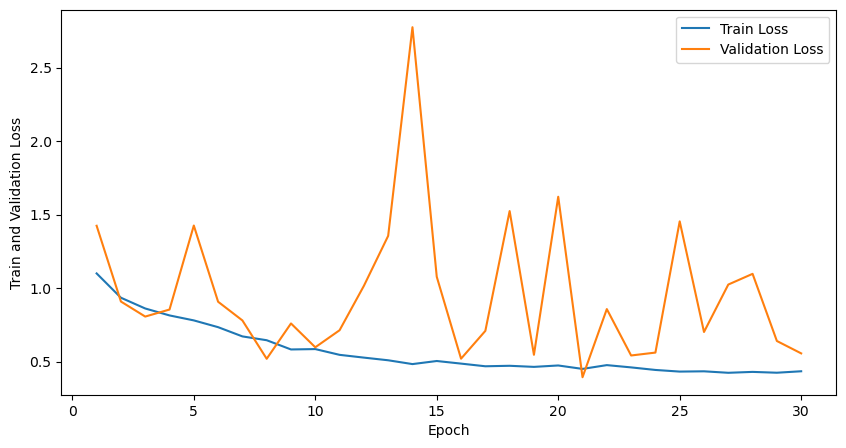

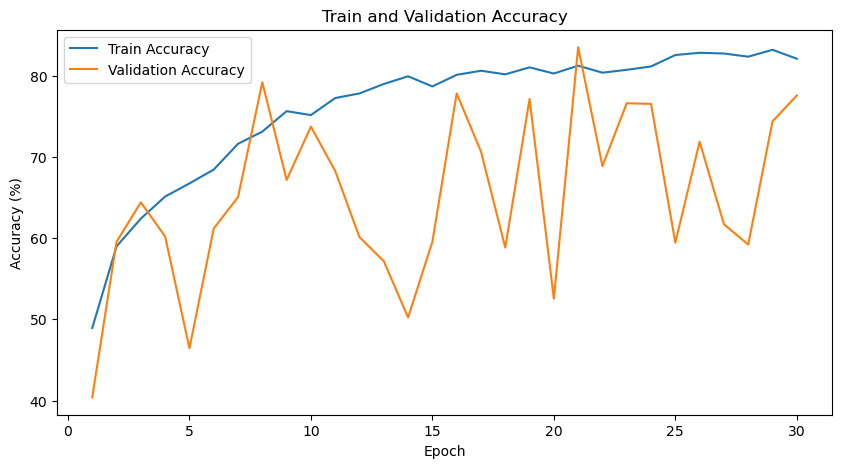

In [45]:
# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Train and Validation Loss')
plt.legend()
plt.show()

# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load('best_model3.pt'))
model.eval()
correct = 0
total = 0

In [ ]:
with torch.no_grad():
  for images, labels in test_dataloader:
    images = images.float().to(device)
    labels = labels.to(device)
    
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    
    total += labels.size(0)
    correct += (predicted == labels).sum().item()
    

test_accuracy = 100 * correct / total 
print(f"Test Accuracy: {test_accuracy:.2f}%")


Test Accuracy: 85.30%


## 전이학습 Efficient net

In [6]:
# 데이터셋 경로
data_path = 'C:/Users/jungh/final_project/preprocessed_seasons_img'
classes = ['spring', 'summer', 'fall', 'winter']
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [24]:
CFG = {
    'IMG_SIZE':224,
    'EPOCHS':30,
    'LEARNING_RATE':0.001,
    'BATCH_SIZE':64,
    'SEED':42
}

In [25]:
def seed_everything(seed):
  random.seed(seed)
  os.environ['PYTHONHASHSEED'] = str(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])  # Seed 고정

In [26]:
train_dir = 'C:/Users/jungh/final_project/preprocessed_seasons_img/'
all_img_list = glob.glob(train_dir + '*/*')

In [27]:
df = pd.DataFrame(columns = ['img_path', 'label'])
df['img_path'] = all_img_list
df['label'] = df['img_path'].apply(lambda x: str(x).split('\\')[1])

In [28]:
x_train_temp, x_test, y_train_temp, y_test = train_test_split(df, df['label'], test_size = 0.2, random_state=CFG['SEED'], stratify=df['label'])

# 임시 데이터를 다시 훈련 세트와 검증 세트로 분할 (비율: 75% 훈련, 25% 검증)
x_train, x_val, y_train, y_val = train_test_split(x_train_temp, y_train_temp, test_size=0.25, random_state=CFG['SEED'], stratify=y_train_temp)

In [29]:
le = preprocessing.LabelEncoder()
x_train['label'] = le.fit_transform(x_train.label)
x_val['label'] = le.transform(x_val['label'])
x_test['label'] = le.transform(x_test['label'])

In [30]:
class CustomDataset(Dataset):
    def __init__(self, img_path_list, label_list, transforms=None):
        self.img_path_list = img_path_list
        self.label_list = label_list
        self.transforms = transforms
        
    def __getitem__(self, index):
        img_path = self.img_path_list[index]
        
        image = cv2.imread(img_path)
        
        if self.transforms is not None:
            image = self.transforms(image=image)['image']
        
        if self.label_list is not None:
            label = self.label_list[index]
            return image, label
        else:
            return image
        
    def __len__(self):
        return len(self.img_path_list)

In [31]:
train_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406),std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])
val_transform = A.Compose([
                            A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
                            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
                            ToTensorV2()
                            ])

In [32]:
train_dataset = CustomDataset(x_train['img_path'].values, x_train['label'].values, train_transform)
train_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True, num_workers=0)

val_dataset = CustomDataset(x_val['img_path'].values, x_val['label'].values, val_transform)
val_loader = DataLoader(val_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

test_dataset = CustomDataset(x_test['img_path'].values, x_test['label'].values, train_transform)
test_loader = DataLoader(train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, num_workers=0)

In [33]:
weights = torchvision.models.EfficientNet_B1_Weights.DEFAULT # .DEFAULT = best available weights from pretraining on ImageNet
model = torchvision.models.efficientnet_b1(weights=weights).to(device)

In [34]:
# Freeze all base layers in the "features" section of the model (the feature extractor) by setting requires_grad=False
for param in model.features.parameters():
    param.requires_grad = False

In [35]:
torch.manual_seed(CFG['SEED'])
torch.cuda.manual_seed(CFG['SEED'])

output_shape = 4

model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.2, inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=output_shape,
                    bias=True)).to(device)

In [43]:
def train(model, optimizer, train_loader, val_loader, scheduler, device):
    model.to(device)
    criterion = nn.CrossEntropyLoss().to(device)
    
    best_score = 0
    best_model = None
    train_losses = []  # 훈련 손실 기록
    val_losses = []    # 검증 손실 기록
    val_accuracies = []  # 검증 정확도 기록
    train_accuracies = []  # 훈련 정확도 기록
    
    for epoch in range(1, CFG['EPOCHS']+1):
        model.train()
        train_loss = []
        correct_train = 0
        total_train = 0
        
        for imgs, labels in tqdm(iter(train_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            optimizer.zero_grad()
            
            output = model(imgs)
            loss = criterion(output, labels)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
            _, predicted_train = torch.max(output.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
            
        train_accuracy = 100 * correct_train / total_train
        _train_loss = np.mean(train_loss)
        train_losses.append(_train_loss)
        train_accuracies.append(train_accuracy)
        
        _val_loss, _val_score = validation(model, criterion, val_loader, device)
        val_losses.append(_val_loss)
        val_accuracies.append(_val_score)
        
        print(f'Epoch [{epoch}], Train Loss : [{_train_loss:.5f}] Train Accuracy : [{train_accuracy:.5f}] Val Loss : [{_val_loss:.5f}] Val Weighted F1 Score : [{_val_score:.5f}]')
       
        if scheduler is not None:
            scheduler.step(_val_score)
            
        if best_score < _val_score:
            best_score = _val_score
            best_model = model
           
    return best_model, train_losses, val_losses, train_accuracies, val_accuracies

def validation(model, criterion, val_loader, device):
    model.eval()
    val_loss = []
    preds, true_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(iter(val_loader)):
            imgs = imgs.float().to(device)
            labels = labels.type(torch.LongTensor).to(device)
            
            pred = model(imgs)
            
            loss = criterion(pred, labels)
            
            preds += pred.argmax(1).detach().cpu().numpy().tolist()
            true_labels += labels.detach().cpu().numpy().tolist()
            
            val_loss.append(loss.item())
        
        _val_loss = np.mean(val_loss)
        _val_score = f1_score(true_labels, preds, average='weighted')
    
    return _val_loss, _val_score

model.eval()
optimizer = torch.optim.Adam(params=model.parameters(), lr=CFG["LEARNING_RATE"])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, threshold_mode='abs', min_lr=1e-8, verbose=True)

infer_model, train_losses, val_losses, train_accuracies, val_accuracies = train(model, optimizer, train_loader, val_loader, scheduler, device)

  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [1], Train Loss : [0.91892] Train Accuracy : [62.41950] Val Loss : [0.83640] Val Weighted F1 Score : [0.66103]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [2], Train Loss : [0.88936] Train Accuracy : [63.65703] Val Loss : [0.81426] Val Weighted F1 Score : [0.67771]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [3], Train Loss : [0.87356] Train Accuracy : [63.92221] Val Loss : [0.80251] Val Weighted F1 Score : [0.67592]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [4], Train Loss : [0.85733] Train Accuracy : [65.32390] Val Loss : [0.79273] Val Weighted F1 Score : [0.67623]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [5], Train Loss : [0.85141] Train Accuracy : [65.07135] Val Loss : [0.77207] Val Weighted F1 Score : [0.68706]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [6], Train Loss : [0.84201] Train Accuracy : [65.33653] Val Loss : [0.76471] Val Weighted F1 Score : [0.68540]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [7], Train Loss : [0.83956] Train Accuracy : [65.17237] Val Loss : [0.75879] Val Weighted F1 Score : [0.68686]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [8], Train Loss : [0.82711] Train Accuracy : [65.91741] Val Loss : [0.75237] Val Weighted F1 Score : [0.69091]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [9], Train Loss : [0.83263] Train Accuracy : [65.33653] Val Loss : [0.74488] Val Weighted F1 Score : [0.69324]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [10], Train Loss : [0.82656] Train Accuracy : [66.38464] Val Loss : [0.74330] Val Weighted F1 Score : [0.68991]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [11], Train Loss : [0.81144] Train Accuracy : [66.83925] Val Loss : [0.73492] Val Weighted F1 Score : [0.68995]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [12], Train Loss : [0.82290] Train Accuracy : [65.80376] Val Loss : [0.72711] Val Weighted F1 Score : [0.69750]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [13], Train Loss : [0.81767] Train Accuracy : [66.68771] Val Loss : [0.73260] Val Weighted F1 Score : [0.69918]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [14], Train Loss : [0.80448] Train Accuracy : [66.27099] Val Loss : [0.72541] Val Weighted F1 Score : [0.69875]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [15], Train Loss : [0.80665] Train Accuracy : [66.67509] Val Loss : [0.72514] Val Weighted F1 Score : [0.69773]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [16], Train Loss : [0.81305] Train Accuracy : [65.98055] Val Loss : [0.71076] Val Weighted F1 Score : [0.69820]
Epoch 00016: reducing learning rate of group 0 to 5.0000e-04.


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [17], Train Loss : [0.79720] Train Accuracy : [67.09180] Val Loss : [0.71519] Val Weighted F1 Score : [0.69757]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [18], Train Loss : [0.80402] Train Accuracy : [66.72560] Val Loss : [0.72299] Val Weighted F1 Score : [0.70156]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [19], Train Loss : [0.80117] Train Accuracy : [67.11706] Val Loss : [0.72392] Val Weighted F1 Score : [0.69613]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [20], Train Loss : [0.79911] Train Accuracy : [67.11706] Val Loss : [0.71222] Val Weighted F1 Score : [0.70619]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [21], Train Loss : [0.79607] Train Accuracy : [66.77611] Val Loss : [0.71402] Val Weighted F1 Score : [0.70568]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [22], Train Loss : [0.78674] Train Accuracy : [67.04129] Val Loss : [0.71183] Val Weighted F1 Score : [0.69908]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [23], Train Loss : [0.80389] Train Accuracy : [66.37202] Val Loss : [0.71732] Val Weighted F1 Score : [0.70172]
Epoch 00023: reducing learning rate of group 0 to 2.5000e-04.


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [24], Train Loss : [0.79921] Train Accuracy : [67.58429] Val Loss : [0.71339] Val Weighted F1 Score : [0.70192]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [25], Train Loss : [0.79646] Train Accuracy : [66.87713] Val Loss : [0.71683] Val Weighted F1 Score : [0.70297]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [26], Train Loss : [0.80017] Train Accuracy : [66.77611] Val Loss : [0.71043] Val Weighted F1 Score : [0.70160]
Epoch 00026: reducing learning rate of group 0 to 1.2500e-04.


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [27], Train Loss : [0.78659] Train Accuracy : [67.38225] Val Loss : [0.71809] Val Weighted F1 Score : [0.70219]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [28], Train Loss : [0.77999] Train Accuracy : [67.52115] Val Loss : [0.70586] Val Weighted F1 Score : [0.70724]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [29], Train Loss : [0.78767] Train Accuracy : [67.53378] Val Loss : [0.70362] Val Weighted F1 Score : [0.70528]


  0%|          | 0/124 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

Epoch [30], Train Loss : [0.79215] Train Accuracy : [67.01604] Val Loss : [0.70801] Val Weighted F1 Score : [0.70235]


In [44]:
print(train_losses)
print(val_losses)
print(train_accuracies)
print(val_accuracies)

[0.9189241980352709, 0.8893592458578848, 0.8735575829782793, 0.8573344503679583, 0.8514088796031091, 0.8420118833741834, 0.8395562234424776, 0.8271078928824394, 0.8326294532706661, 0.8265622128402034, 0.8114436696613988, 0.8228968521279674, 0.8176673136411174, 0.8044822831307689, 0.8066540591178402, 0.813049374568847, 0.7972006591097001, 0.8040155547280465, 0.8011677308428672, 0.7991108173324216, 0.7960654501953432, 0.7867445407375213, 0.8038948341723411, 0.7992064404872156, 0.7964578222843909, 0.800174827537229, 0.7865898686070596, 0.7799911297136738, 0.7876677099735506, 0.79214873861882]
[0.8363980438028064, 0.8142590380850292, 0.8025135199228922, 0.7927288824603671, 0.7720736208416167, 0.7647141360101246, 0.7587918624991462, 0.7523659297398159, 0.7448834124065581, 0.7432977855205536, 0.7349195948668888, 0.7271142445859455, 0.7326011856396993, 0.7254092253389812, 0.7251367810226622, 0.7107600356851306, 0.715186996119363, 0.7229915388992855, 0.723918175413495, 0.7122202089854649, 0.71

In [49]:
type(val_accuracies)

list

In [51]:
val_accuracies = [num * 100 for num in val_accuracies]

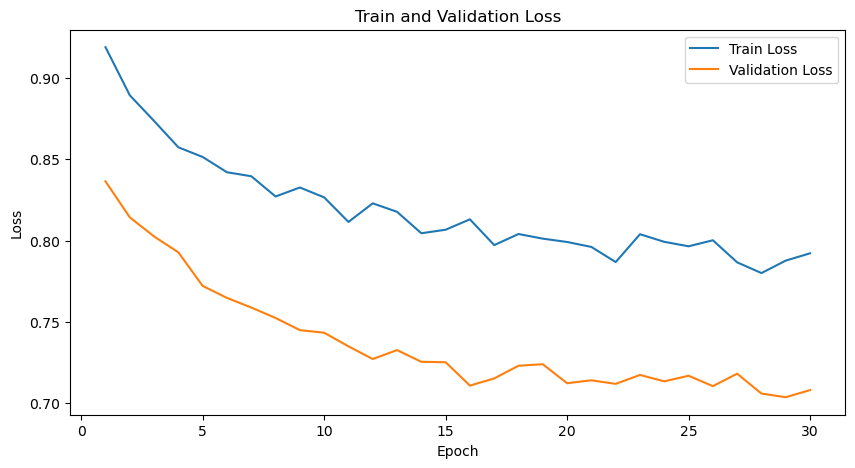

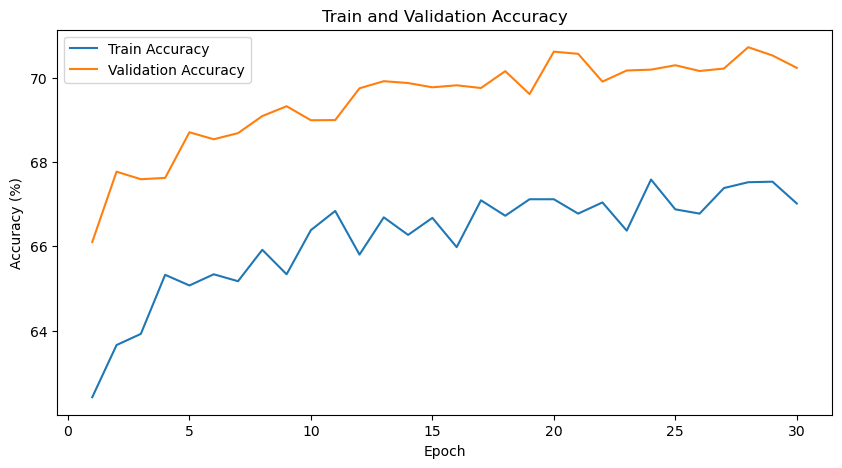

In [53]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, CFG['EPOCHS']+1), train_losses, label="Train Loss")
plt.plot(range(1, CFG['EPOCHS']+1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()

# 훈련 정확도와 검증 정확도 그래프
plt.figure(figsize=(10, 5))
plt.plot(range(1, CFG['EPOCHS']+1), train_accuracies, label="Train Accuracy")
plt.plot(range(1, CFG['EPOCHS']+1), val_accuracies, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train and Validation Accuracy")
plt.legend()
plt.show()

In [50]:
val_accuracies[0] * 100

66.10299269260517